## LikelihoodProfiler local optimizers comparison

Here we compare the efficiency of local derivative-free optimization algorithms applied to *Identifiability Analysis* with *LikelihoodProfiler* package. The following algorithms from *NLopt* library are compared on the basis of 
1. Number of loss function evaluation
2. How precise confidence inteval boundaries are estimated

In [93]:
using NLopt, Plots, LaTeXStrings, DataFrames, LikelihoodProfiler
# Algorithms list
algs = [
    :LN_NELDERMEAD,
    :LN_SBPLX,
    :LN_COBYLA,
    :LN_BOBYQA,
    :LN_PRAXIS
]

5-element Array{Symbol,1}:
 :LN_NELDERMEAD
 :LN_SBPLX     
 :LN_COBYLA    
 :LN_BOBYQA    
 :LN_PRAXIS    

The following loss function will be used for Parameters Identification:
$\Lambda(\theta) = 5 + (\theta_1-3)^2 + (exp(\theta_2)-1)^2 + 0*\theta_3$. We choose identification confidence level 𝛼=𝑙𝑜𝑠𝑠+3.84, where 𝑙𝑜𝑠𝑠 is the minimum loss function value obtained during fitting and 3.84 is Chi-square statistics with 1 degree of freedom and P-value=0.05.

In [89]:
# likelihood function
Λ(θ) = 5.0 + (θ[1]-3.0)^2 + (exp(θ[2])-1.0)^2 + 0.0*θ[3]
α = 5.0 + 3.84;

Let's plot the profiles for $\Lambda(\theta_1), \Lambda(\theta_2), \Lambda(\theta_3)$

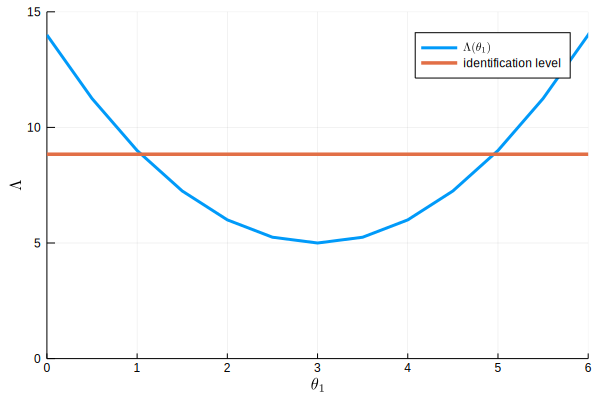

In [82]:

t = collect(0.0:0.5:10.0)
p1 = plot(t,[Λ([t_i,0.0,0.0]) for t_i in t],
          xlabel="\$\\theta_1\$",
          ylabel="\$\\Lambda\$",
          label="\$\\Lambda(\\theta_1)\$",
          xlims=(0.0,6.0),
          ylims=(0.0,15.),
          linewidth = 3.0);
plot!(x->α, linewidth = 3.5, label="identification level")
p2 = plot(t,[Λ([3.0,t_i,0.0]) for t_i in t],
          xlabel="\$\\theta_2\$",
          ylabel="\$\\Lambda\$",
          label="\$\\Lambda(\\theta_2)\$",
          xlims=(0.0,2.0),
          ylims=(0.0,20.),
          linewidth = 3.0);
plot!(x->α, linewidth = 3.5, label="identification level")
p3 = plot(t,[Λ([3.0,0.0,t_i]) for t_i in t], 
          xlabel="\$\\theta_3\$",
          ylabel="\$\\Lambda\$",
          label="\$\\Lambda(\\theta_3)\$",
          ylims=(0.0,15.),
          linewidth = 3.0);
plot!(x->α, linewidth = 3.5, label="identification level");

plot(p1)

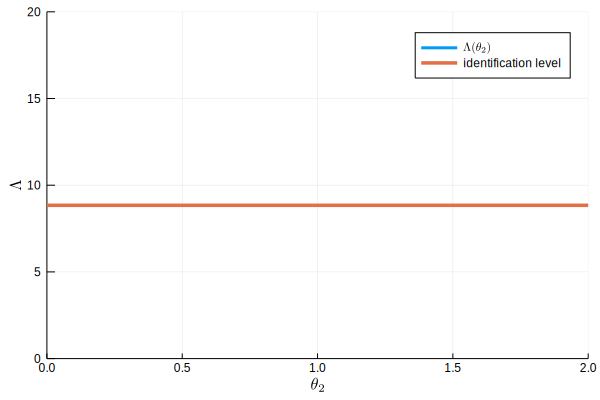

In [83]:
plot(p2)

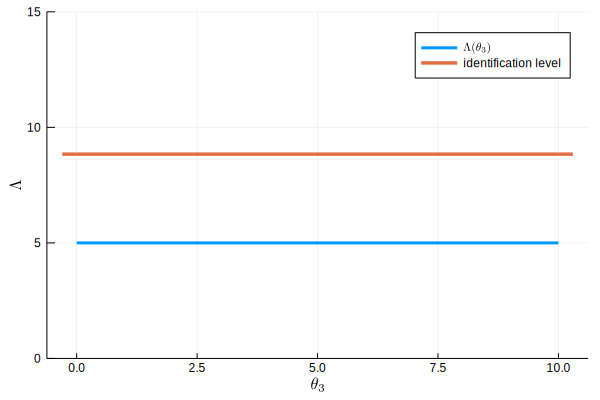

In [84]:
plot(p3)

Exact values for confidence intervals boundaries can be computed anlytically

In [91]:
# confidence intervals
exact_ci = DataFrame(
    params = [:θ₁, :θ₂, :θ₃],
    ci_lower = [-sqrt(3.84)+3.0, nothing, nothing],
    ci_upper = [sqrt(3.84)+3.0, log(sqrt(3.84)+1.0), nothing]
);
show(exact_ci)

3×3 DataFrame
│ Row │ params │ ci_lower │ ci_upper │
│     │ Symbol │ Union…   │ Union…   │
├─────┼────────┼──────────┼──────────┤
│ 1   │ θ₁     │ 1.04041  │ 4.95959  │
│ 2   │ θ₂     │          │ 1.08505  │
│ 3   │ θ₃     │          │          │

Now we compute the same confidence intervals with *LikelihoodProfiler* package and the list of derivative-free optimization algorithms.

In [104]:
df = Dict{Symbol,DataFrame}()

for alg in algs
    res = [get_interval(
        [3., 0.1, 0.1], # :LN_NELDERMEAD is not stable when starting from values close to zero
        i,
        Λ,
        :CICO_ONE_PASS;
        loss_crit=α,
        local_alg=alg,
    ) for i in 1:3]
    
    df[alg] = DataFrame(
        params = params = [:θ₁, :θ₂, :θ₃],
        ci_lower_status = [p.result[1].status for p in res],
        ci_lower_count = [p.result[1].counter for p in res],
        ci_lower_value = [p.result[1].value for p in res],
        ci_upper_status = [p.result[2].status for p in res],
        ci_upper_count = [p.result[2].counter for p in res],
        ci_upper_value = [p.result[2].value for p in res]
    )
end

┌ Warning: Using local_alg = :LN_SBPLX may result in wrong output.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:29
┌ Warning: Using local_alg = :LN_SBPLX may result in wrong output.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:29
┌ Warning: Using local_alg = :LN_SBPLX may result in wrong output.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:29
┌ Warning: Using local_alg = :LN_SBPLX may result in wrong output.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:29
┌ Warning: Using local_alg = :LN_SBPLX may result in wrong output.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:29
┌ Warning: Using local_alg = :LN_SBPLX may result in wrong output.
└ @ LikelihoodProfiler D:\INSYSBIO\repos\LikelihoodProfiler\src\cico_one_pass.jl:29
┌ Warning: Using local_alg = :LN_BOBYQA may result in wrong output.
└ @ LikelihoodProfiler D:\

Results for *LN_NELDERMEAD, LN_SBPLX, LN_COBYLA, LN_BOBYQA, LN_PRAXIS*

In [105]:
show(df[:LN_NELDERMEAD],allcols=true)

3×7 DataFrame
│ Row │ params │ ci_lower_status          │ ci_lower_count │ ci_lower_value │
│     │ Symbol │ Symbol                   │ Int64          │ Union…         │
├─────┼────────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ θ₁     │ BORDER_FOUND_BY_SCAN_TOL │ 292            │ 1.04059        │
│ 2   │ θ₂     │ SCAN_BOUND_REACHED       │ 37             │                │
│ 3   │ θ₃     │ SCAN_BOUND_REACHED       │ 37             │                │

│ Row │ ci_upper_status          │ ci_upper_count │ ci_upper_value │
│     │ Symbol                   │ Int64          │ Union…         │
├─────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ BORDER_FOUND_BY_SCAN_TOL │ 204            │ 4.95941        │
│ 2   │ BORDER_FOUND_BY_SCAN_TOL │ 257            │ 1.08468        │
│ 3   │ SCAN_BOUND_REACHED       │ 52             │                │

In [106]:
show(df[:LN_SBPLX],allcols=true)

3×7 DataFrame
│ Row │ params │ ci_lower_status          │ ci_lower_count │ ci_lower_value │
│     │ Symbol │ Symbol                   │ Int64          │ Union…         │
├─────┼────────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ θ₁     │ BORDER_FOUND_BY_SCAN_TOL │ 535            │ 1.04047        │
│ 2   │ θ₂     │ SCAN_BOUND_REACHED       │ 42             │                │
│ 3   │ θ₃     │ SCAN_BOUND_REACHED       │ 18             │                │

│ Row │ ci_upper_status          │ ci_upper_count │ ci_upper_value │
│     │ Symbol                   │ Int64          │ Union…         │
├─────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ BORDER_FOUND_BY_SCAN_TOL │ 449            │ 4.95884        │
│ 2   │ BORDER_FOUND_BY_SCAN_TOL │ 470            │ 1.08505        │
│ 3   │ SCAN_BOUND_REACHED       │ 18             │                │

In [107]:
show(df[:LN_COBYLA],allcols=true)

3×7 DataFrame
│ Row │ params │ ci_lower_status          │ ci_lower_count │ ci_lower_value │
│     │ Symbol │ Symbol                   │ Int64          │ Union…         │
├─────┼────────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ θ₁     │ BORDER_FOUND_BY_SCAN_TOL │ 142            │ 1.04068        │
│ 2   │ θ₂     │ SCAN_BOUND_REACHED       │ 371            │                │
│ 3   │ θ₃     │ SCAN_BOUND_REACHED       │ 371            │                │

│ Row │ ci_upper_status          │ ci_upper_count │ ci_upper_value │
│     │ Symbol                   │ Int64          │ Union…         │
├─────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ BORDER_FOUND_BY_SCAN_TOL │ 171            │ 4.95662        │
│ 2   │ BORDER_FOUND_BY_SCAN_TOL │ 185            │ 1.08489        │
│ 3   │ SCAN_BOUND_REACHED       │ 184            │                │

In [108]:
show(df[:LN_BOBYQA],allcols=true)

3×7 DataFrame
│ Row │ params │ ci_lower_status          │ ci_lower_count │ ci_lower_value │
│     │ Symbol │ Symbol                   │ Int64          │ Union…         │
├─────┼────────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ θ₁     │ BORDER_FOUND_BY_SCAN_TOL │ 13             │ 2.94939        │
│ 2   │ θ₂     │ SCAN_BOUND_REACHED       │ 15             │                │
│ 3   │ θ₃     │ SCAN_BOUND_REACHED       │ 15             │                │

│ Row │ ci_upper_status          │ ci_upper_count │ ci_upper_value │
│     │ Symbol                   │ Int64          │ Union…         │
├─────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ BORDER_FOUND_BY_SCAN_TOL │ 13             │ 3.05061        │
│ 2   │ BORDER_FOUND_BY_SCAN_TOL │ 23             │ 0.930661       │
│ 3   │ SCAN_BOUND_REACHED       │ 15             │                │

In [109]:
show(df[:LN_PRAXIS],allcols=true)

3×7 DataFrame
│ Row │ params │ ci_lower_status          │ ci_lower_count │ ci_lower_value │
│     │ Symbol │ Symbol                   │ Int64          │ Union…         │
├─────┼────────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ θ₁     │ BORDER_FOUND_BY_SCAN_TOL │ 1312           │ 1.04068        │
│ 2   │ θ₂     │ SCAN_BOUND_REACHED       │ 162            │                │
│ 3   │ θ₃     │ SCAN_BOUND_REACHED       │ 213            │                │

│ Row │ ci_upper_status          │ ci_upper_count │ ci_upper_value │
│     │ Symbol                   │ Int64          │ Union…         │
├─────┼──────────────────────────┼────────────────┼────────────────┤
│ 1   │ BORDER_FOUND_BY_SCAN_TOL │ 1395           │ 4.95961        │
│ 2   │ BORDER_FOUND_BY_SCAN_TOL │ 210            │ 1.08505        │
│ 3   │ SCAN_BOUND_REACHED       │ 189            │                │